In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score
import torch.nn.functional as nnf
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
from cnm.scene_lvl.crnn_orig.model import ResCNNEncoder, DecoderRNN
import cnm.scene_lvl.crnn_orig.dataset_loader as rescnn_dataset_loader

import cnm.scene_lvl.i3d.dataset_loader as cnn3d_dataset_loader
from cnm.scene_lvl.i3d.model import CNN3D

from cnm.scene_lvl.i3d.model import Conv3d_final_prediction
from cnm.scene_lvl.crnn_orig.model import crnn_final_prediction

# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


## CNN+LSTM

In [3]:
batch_size = 16
h_res_size = 224
w_res_size = 224
forward_frame_len = 20
backward_frame_len = 20

csv_data_path = r"/project/6055479/lingheng/cyc_near_miss/dataset_utils/dataset_vic_cyc_legacy/NearMiss_classification.csv"
rgb_frame_data_path = r"/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_rgb_frame/"
opt_frame_data_path = r"/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_opt_frame/"
fused_frame_data_path = r"/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_fused_frame/"

CNN_fc_hidden1 = 1024
CNN_fc_hidden2 = 768
dropout_p = 0.1
CNN_embed_dim = 512

RNN_hidden_layers= 3 
RNN_hidden_nodes = 512
RNN_FC_dim = 256
num_classes = 2

In [4]:
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}

transform = transforms.Compose([transforms.Resize([h_res_size, w_res_size]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [5]:
def crnn_final_prediction(model, device, loader):
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()

    all_y_pred = []
    all_y = []
    all_output = []
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(tqdm(loader)):
            # distribute data to device
            if isinstance(X, list):  # For 2-streams, X is a tuple of (rgb, opt)
                X = (X[0].to(device), X[1].to(device))
                y = y.to(device).view(-1, )
            else:
                X, y = X.to(device), y.to(device).view(-1, )
            
            output = rnn_decoder(cnn_encoder(X))
            y_pred = output.max(1, keepdim=True)[1]  # location of max log-probability as prediction
            
            all_output.extend(output)
            all_y_pred.extend(y_pred.cpu().data.squeeze().numpy().tolist())
            all_y.extend(y.cpu().data.squeeze().numpy().tolist())
    return all_y, all_y_pred, all_output

In [6]:
CNN_LSTM_rgb_input_results_root_dir = r"/scratch/lingheng/cyc_safety_project_results/New_CNN_LSTM_rgb_only_input"
CNN_LSTM_fused_input_results_root_dir = r"/scratch/lingheng/cyc_safety_project_results/New_CNN_LSTM_fused_input"
CNN_LSTM_rgb_and_opt_input_results_root_dir = r"/scratch/lingheng/cyc_safety_project_results/New_CNN_LSTM_rgb_and_opt_input/"

# CNN_LSTM_rgb_input_results_root_dir = r"/scratch/lingheng/cyc_safety_project_results/CNN_LSTM_rgb_only_input"
# CNN_LSTM_fused_input_results_root_dir = r"/scratch/lingheng/cyc_safety_project_results/CNN_LSTM_fused_input"
# CNN_LSTM_rgb_and_opt_input_results_root_dir = r"/scratch/lingheng/cyc_safety_project_results/CNN_LSTM_rgb_and_opt_input/"


training_losses_file = "CRNN_epoch_training_losses.npy"
training_scores_file = "CRNN_epoch_training_scores.npy"
test_score_file = "CRNN_epoch_test_score.npy"
test_loss_file = "CRNN_epoch_test_loss.npy"

input_type_dir = {'RGB': CNN_LSTM_rgb_input_results_root_dir, 
                  'Fused': CNN_LSTM_fused_input_results_root_dir, 
                  'RGB and OPT': CNN_LSTM_rgb_and_opt_input_results_root_dir}

best_model_dict = {'RGB': {'run_name': 'crnn_orig_run_0', 'epoch': 27},
                   'Fused': {'run_name': 'crnn_orig_run_1', 'epoch': 27},
                   'RGB and OPT': {'run_name': 'crnn_orig_run_3', 'epoch': 25}}

input_type_dict = {'RGB': 'rgb_only', 'Fused': 'fused', 'RGB and OPT': 'rgb_and_opt'}

cnn_lstm_pred_dict = {}

for input_type_name in best_model_dict:
    print(input_type_name)
    # Initialize
    input_type = input_type_dict[input_type_name]
    train_set, valid_set = rescnn_dataset_loader.VicCycLegacyDataset(csv_data_path,
                                               rgb_frame_data_path, opt_frame_data_path, fused_frame_data_path,
                                               split='train',
                                               forward_frame_len=forward_frame_len,
                                               backward_frame_len=backward_frame_len,
                                               input_type=input_type, transform=transform), \
                           rescnn_dataset_loader.VicCycLegacyDataset(csv_data_path,
                                               rgb_frame_data_path, opt_frame_data_path, fused_frame_data_path,
                                               split='test',
                                               forward_frame_len=forward_frame_len,
                                               backward_frame_len=backward_frame_len,
                                               input_type=input_type, transform=transform)

    train_loader = data.DataLoader(train_set, **params)
    valid_loader = data.DataLoader(valid_set, **params)

    # Create model
    cnn_encoder = ResCNNEncoder(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p,
                                CNN_embed_dim=CNN_embed_dim, input_type=input_type).to(device)
    rnn_decoder = DecoderRNN(CNN_embed_dim=CNN_embed_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes,
                             h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=num_classes,
                             input_type=input_type).to(device)
    #
    run_path = os.path.join(input_type_dir[input_type_name], best_model_dict[input_type_name]['run_name'])
    model_epoch = best_model_dict[input_type_name]['epoch']
    print('\t{}, {}'.format(best_model_dict[input_type_name]['run_name'], model_epoch))
    
    #
    cnn_lstm_cnn_encoder_model_state = torch.load(os.path.join(run_path, 'cnn_encoder_epoch{}.pth'.format(model_epoch)))
    cnn_lstm_rnn_decoder_model_state = torch.load(os.path.join(run_path, 'rnn_decoder_epoch{}.pth'.format(model_epoch)))
    # Load
    cnn_encoder.load_state_dict(cnn_lstm_cnn_encoder_model_state)
    rnn_decoder.load_state_dict(cnn_lstm_rnn_decoder_model_state)
    # Predict
    all_y, all_y_pred, all_output = crnn_final_prediction([cnn_encoder, rnn_decoder], device, valid_loader)
    cnn_lstm_pred_dict[input_type_name] = {'all_y': all_y, 'all_y_pred': all_y_pred, 'all_output': all_output}
    
    f1_score_result = f1_score(all_y, all_y_pred, average='binary')
    accuracy_result = accuracy_score(all_y, all_y_pred)
    print('\t\tF1-score={}, Accuracy={}'.format(f1_score_result, accuracy_result))


RGB
	crnn_orig_run_0, 27


100%|██████████| 25/25 [04:59<00:00, 12.00s/it]


		F1-score=0.8894117647058823, Accuracy=0.8813131313131313
Fused
	crnn_orig_run_1, 27


100%|██████████| 25/25 [04:44<00:00, 11.36s/it]


		F1-score=0.8635235732009925, Accuracy=0.8611111111111112
RGB and OPT
	crnn_orig_run_3, 25


100%|██████████| 25/25 [04:55<00:00, 11.82s/it]

		F1-score=0.8873239436619719, Accuracy=0.8787878787878788


## I3D

In [7]:

batch_size = 16
h_res_size = 256
w_res_size = 342
forward_frame_len = 5
backward_frame_len = 15

csv_data_path = r"/project/6055479/lingheng/cyc_near_miss/dataset_utils/dataset_vic_cyc_legacy/NearMiss_classification.csv"
rgb_frame_data_path = r"/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_rgb_frame/"
opt_frame_data_path = r"/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_opt_frame/"
fused_frame_data_path = r"/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_fused_frame/"

fc_hidden1 = 256
fc_hidden2 = 256
dropout_p = 0
num_classes = 2

In [8]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# load UCF101 actions names
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}

# image transformation
transform = transforms.Compose([transforms.Resize([h_res_size, w_res_size]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])


In [9]:
def Conv3d_final_prediction(model, device, loader):
    model.eval()

    all_y_pred, all_y = [], []
    all_output = []
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(tqdm(loader)):
            # distribute data to device
            if isinstance(X, list):  # For 2-streams, X is a tuple of (rgb, opt)
                X = (X[0].to(device), X[1].to(device))
                y = y.to(device).view(-1, )
            else:
                X, y = X.to(device), y.to(device).view(-1, )
            
            output = model(X)
            y_pred = output.max(1, keepdim=True)[1]  # location of max log-probability as prediction
            all_output.extend(output)
            if str(device) == 'cpu':
                all_y_pred.extend(y_pred.data.squeeze().numpy().tolist())
                all_y.extend(y.data.squeeze().numpy().tolist())
            else:
                all_y_pred.extend(y_pred.cpu().data.squeeze().numpy().tolist())
                all_y.extend(y.cpu().data.squeeze().numpy().tolist())
            
    return all_y, all_y_pred, all_output

In [10]:
# i3d_rgb_input_results_root_dir = r"/scratch/lingheng/cyc_safety_project_results/New_i3d_rgb_only_input"
# i3d_fused_input_results_root_dir = r"/scratch/lingheng/cyc_safety_project_results/New_i3d_fused_input"
# i3d_rgb_and_opt_input_results_root_dir = r"/scratch/lingheng/cyc_safety_project_results/New_i3d_rgb_and_opt_input"

i3d_rgb_input_results_root_dir = r"/scratch/lingheng/cyc_safety_project_results/New_i3d_WithDropout_rgb_only_input"
i3d_fused_input_results_root_dir = r"/scratch/lingheng/cyc_safety_project_results/New_i3d_WithDropout_fused_input"
i3d_rgb_and_opt_input_results_root_dir = r"/scratch/lingheng/cyc_safety_project_results/New_i3d_WithDropout_rgb_and_opt_input"


training_losses_file = "3DCNN_epoch_training_losses.npy"
training_scores_file = "3DCNN_epoch_training_scores.npy"
test_score_file = "3DCNN_epoch_test_score.npy"
test_loss_file = "3DCNN_epoch_test_loss.npy"

input_type_dir = {'RGB': i3d_rgb_input_results_root_dir, 
                  'Fused': i3d_fused_input_results_root_dir, 
                  'RGB and OPT': i3d_rgb_and_opt_input_results_root_dir}

# best_model_dict = {'RGB': {'run_name': 'i3d_run_3', 'epoch': 9},
#                    'Fused': {'run_name': 'i3d_run_1', 'epoch': 8},
#                    'RGB and OPT': {'run_name': 'i3d_run_3', 'epoch': 13}}

best_model_dict = {'RGB': {'run_name': 'i3d_run_4', 'epoch': 10},
                   'Fused': {'run_name': 'i3d_run_3', 'epoch': 13},
                   'RGB and OPT': {'run_name': 'i3d_run_2', 'epoch': 29}}

input_type_dict = {'RGB': 'rgb_only', 'Fused': 'fused', 'RGB and OPT': 'rgb_and_opt'}

i3d_pred_dict = {}

for input_type_name in best_model_dict:
    print(input_type_name)
    # Initialize
    input_type = input_type_dict[input_type_name]
    train_set, valid_set = cnn3d_dataset_loader.VicCycLegacyDataset(csv_data_path,
                                               rgb_frame_data_path, opt_frame_data_path, fused_frame_data_path,
                                               split='train',
                                               forward_frame_len=forward_frame_len,
                                               backward_frame_len=backward_frame_len,
                                               input_type=input_type, transform=transform), \
                           cnn3d_dataset_loader.VicCycLegacyDataset(csv_data_path,
                                               rgb_frame_data_path, opt_frame_data_path, fused_frame_data_path,
                                               split='test',
                                               forward_frame_len=forward_frame_len,
                                               backward_frame_len=backward_frame_len,
                                               input_type=input_type, transform=transform)

    train_loader = data.DataLoader(train_set, **params)
    valid_loader = data.DataLoader(valid_set, **params)

    # Create model
    cnn3d = CNN3D(t_dim=forward_frame_len+backward_frame_len, img_x=h_res_size, img_y=w_res_size,
                  drop_p=dropout_p, fc_hidden1=fc_hidden1,  fc_hidden2=fc_hidden2,
                  num_classes=num_classes, input_type=input_type).to(device)
    
    #
    run_path = os.path.join(input_type_dir[input_type_name], best_model_dict[input_type_name]['run_name'])
    model_epoch = best_model_dict[input_type_name]['epoch']
    print('\t{}, {}'.format(best_model_dict[input_type_name]['run_name'], model_epoch))
    
    #
    cnn3d_model_state = torch.load(os.path.join(run_path, '3dcnn_epoch{}.pth'.format(model_epoch)))
    
    # Load
    cnn3d.load_state_dict(cnn3d_model_state)
    
    # Predict
    all_y, all_y_pred, all_output = Conv3d_final_prediction(cnn3d, device, valid_loader)
    i3d_pred_dict[input_type_name] = {'all_y': all_y, 'all_y_pred': all_y_pred, 'all_output': all_output}
    
    f1_score_result = f1_score(all_y, all_y_pred, average='binary')
    accuracy_result = accuracy_score(all_y, all_y_pred)
    print('\t\tF1-score={}, Accuracy={}'.format(f1_score_result, accuracy_result))


RGB
	i3d_run_4, 10


100%|██████████| 25/25 [02:21<00:00,  5.65s/it]


		F1-score=0.8471177944862155, Accuracy=0.8459595959595959
Fused
	i3d_run_3, 13


100%|██████████| 25/25 [01:58<00:00,  4.72s/it]


		F1-score=0.8528678304239401, Accuracy=0.851010101010101
RGB and OPT
	i3d_run_2, 29


100%|██████████| 25/25 [01:58<00:00,  4.72s/it]

		F1-score=0.8205128205128205, Accuracy=0.8232323232323232


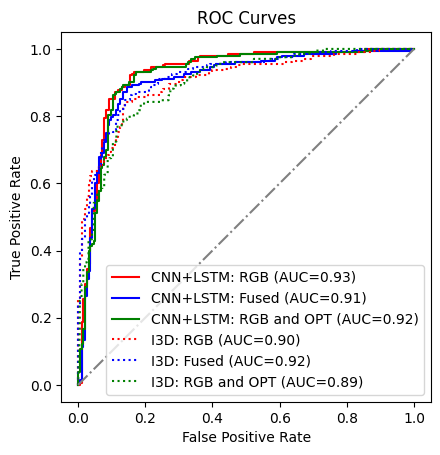

In [40]:
color = {'RGB': 'r', 'Fused': 'b', 'RGB and OPT': 'g'}
fontsize = 10

fig, ax = plt.subplots(1,1)
# CNN+LSTM
for input_type_name in cnn_lstm_pred_dict:
    all_y = cnn_lstm_pred_dict[input_type_name]['all_y']
    all_y_pred = cnn_lstm_pred_dict[input_type_name]['all_y_pred']
    all_output = torch.stack(cnn_lstm_pred_dict[input_type_name]['all_output'])
    
    pred_prob = nnf.softmax(all_output, dim=1).cpu().data.squeeze().numpy()
    
    ns_auc = roc_auc_score(all_y, pred_prob[:,1])
    lr_fpr, lr_tpr, _ = roc_curve(all_y, pred_prob[:,1])

    # plot the roc curve for the model
    ax.plot(lr_fpr, lr_tpr, label='CNN+LSTM: {} (AUC={:.2f})'.format(input_type_name, ns_auc), linestyle='-', color=color[input_type_name])

# I3D
for input_type_name in i3d_pred_dict:
    all_y = i3d_pred_dict[input_type_name]['all_y']
    all_y_pred = i3d_pred_dict[input_type_name]['all_y_pred']
    all_output = torch.stack(i3d_pred_dict[input_type_name]['all_output'])
    
    pred_prob = nnf.softmax(all_output, dim=1).cpu().data.squeeze().numpy()
    
    ns_auc = roc_auc_score(all_y, pred_prob[:,1])
    lr_fpr, lr_tpr, _ = roc_curve(all_y, pred_prob[:,1])

    # plot the roc curve for the model
    # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax.plot(lr_fpr, lr_tpr, label='I3D: {} (AUC={:.2f})'.format(input_type_name, ns_auc), linestyle=':', color=color[input_type_name])

ax.plot(lr_fpr, lr_fpr, linestyle='-.', color='gray')
    
# axis labels
ax.set_xlabel('False Positive Rate', fontsize=fontsize)
ax.set_ylabel('True Positive Rate', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
# show the legend
ax.legend(fontsize=fontsize, loc='lower right')
ax.set_aspect('equal', adjustable='box')
ax.set_title('ROC Curves', fontsize=fontsize+2)
fig.savefig('./roc.png', dpi=400, bbox_inches='tight', pad_inches=0)